In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Para evitar os vários warnings nos modelos KMeans (precisa ser executado antes de qualquer biblioteca)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    PowerTransformer, StandardScaler
)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

sns.set_theme(palette="bright")

from src.graficos import grafico_elbow_silhouette, visualizar_clusters_3d

RANDOM_STATE = 42

In [3]:
df = pd.read_csv("../dados/Mall_Customer_no_CustomerID.csv")
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
df.nunique()

Gender                     2
Age                       51
Annual Income (k$)        64
Spending Score (1-100)    84
dtype: int64

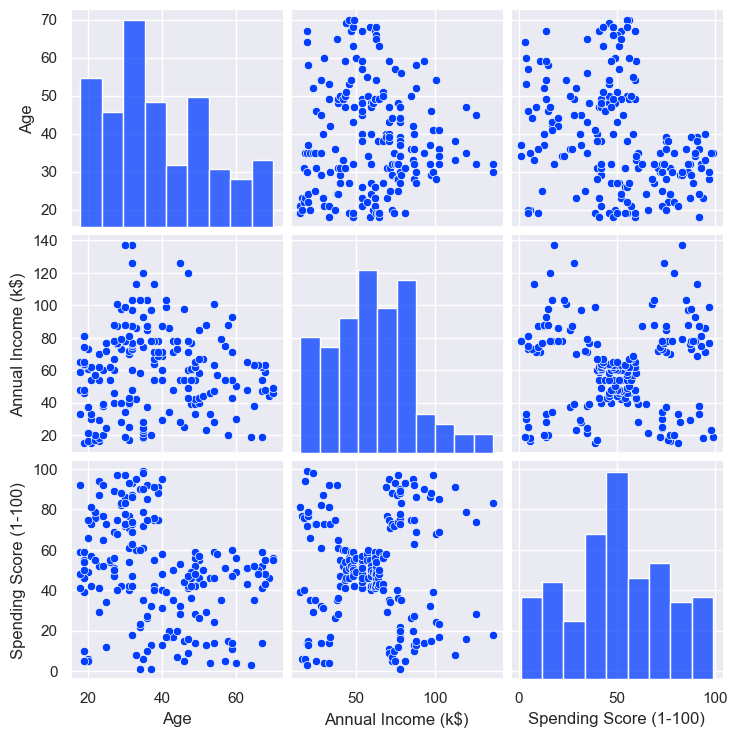

In [6]:
sns.pairplot(df)

#### Separando as colunas pelo tipo

In [7]:
colunas_categoricas = ['Gender']
colunas_numericas = df.drop(columns='Gender').columns

#### Definir Preprocessamento

In [8]:
preprocessamento = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), colunas_numericas),
        ('one_hot', OneHotEncoder(), colunas_categoricas),
    ], remainder= 'passthrough'
)

preprocessamento

ColumnTransformer(remainder='passthrough',
                  transformers=[('standard', StandardScaler(),
                                 Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                ('one_hot', OneHotEncoder(), ['Gender'])])

#### Analisando a transformação do dataframe após preprocessamento

In [9]:
df_preprocessado = pd.DataFrame(
    preprocessamento.fit_transform(df),
    columns=preprocessamento.get_feature_names_out()
)

df_preprocessado.head()

,standard__Age,standard__Annual Income (k$),standard__Spending Score (1-100),one_hot__Gender_Female,one_hot__Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0


In [10]:
#df_preprocessado.to_csv("../dados/Mall_Customers_scaled.csv")

#### Estudo para determinar número de componentes da PCA

In [11]:
df_estudo_pca = df.copy()

In [12]:
estudo_pca = Pipeline([
    ('preprocessamento', preprocessamento),
    ('pca', PCA())
])

estudo_pca

estudo_pca.fit(df_estudo_pca)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                                 ('one_hot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA())])

In [13]:
estudo_pca['pca'].components_

array([[ 7.05084245e-01, -3.92153090e-02, -7.04735075e-01,
        -4.83054913e-02,  4.83054913e-02],
       [ 2.02438681e-02,  9.96114996e-01, -2.73003790e-02,
        -5.74447138e-02,  5.74447138e-02],
       [ 7.06616429e-01,  4.34966718e-03,  7.07534128e-01,
        -5.90595130e-03,  5.90595130e-03],
       [ 5.60322796e-02,  7.87283629e-02, -4.47059316e-02,
         7.03087337e-01, -7.03087337e-01],
       [ 5.58828395e-18, -2.87340676e-16, -6.46696466e-17,
         7.07106781e-01,  7.07106781e-01]])

In [14]:
estudo_pca['pca'].explained_variance_ratio_

array([0.38132566, 0.28707805, 0.19261822, 0.13897807, 0.        ])

In [15]:
np.cumsum(estudo_pca['pca'].explained_variance_ratio_)

array([0.38132566, 0.66840371, 0.86102193, 1.        , 1.        ])

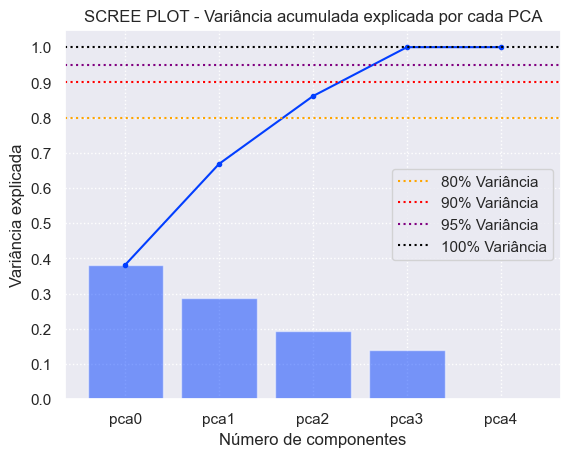

In [16]:
fig, ax = plt.subplots()

ax.bar(estudo_pca['pca'].get_feature_names_out(),
        estudo_pca['pca'].explained_variance_ratio_,
        alpha=0.5)

ax.plot(np.cumsum(estudo_pca['pca'].explained_variance_ratio_), marker='.')

ax.axhline(y=0.8, color='orange', linestyle=":", label="80% Variância")
ax.axhline(y=0.9, color='red', linestyle=":", label="90% Variância")
ax.axhline(y=0.95, color='purple', linestyle=":", label="95% Variância")
ax.axhline(y=1, color='black', linestyle=":", label="100% Variância")

ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid(linestyle=':')
ax.legend()
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Variância explicada')
ax.set_title('SCREE PLOT - Variância acumulada explicada por cada PCA')

plt.show()

**Conclusão:** Podemos usar PCA = 4 para explicar 100% da variância dos dados, ou PCA = 3 já é capaz de justificar 85% da variância dos dados. 

- Será escolhido PCA=3

#### Estudo para determinar número de Clusters (K)

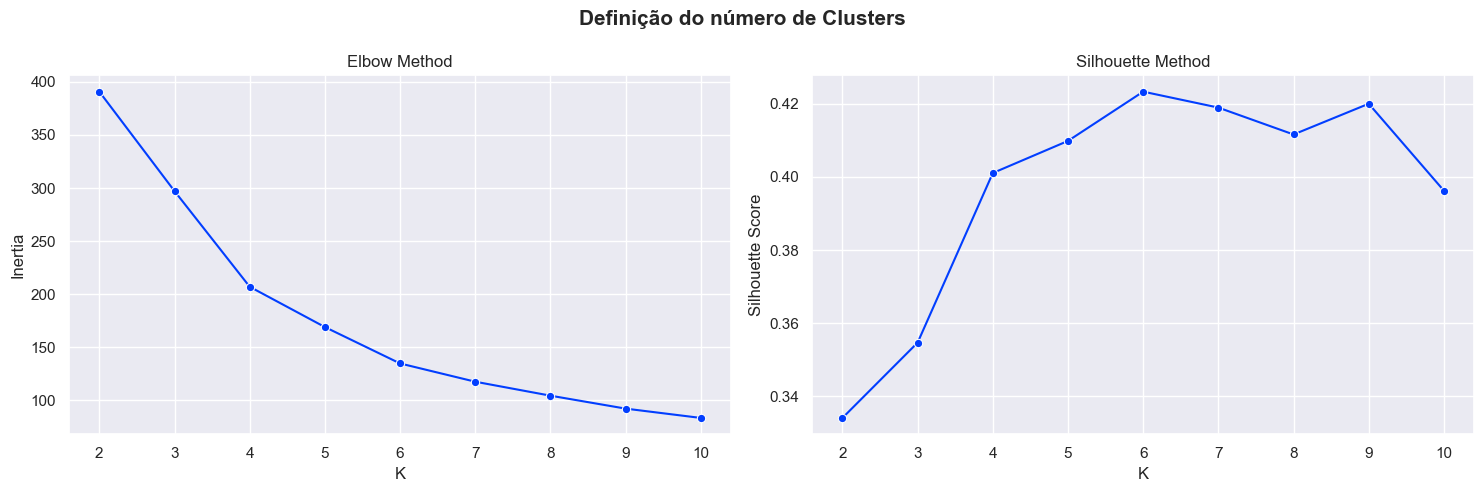

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), tight_layout=True)

elbow = {}
silhouette = []

X = df

k_range = range(2,11)

for numero in k_range:
    kmeans = Pipeline([
        ('preprocessamento', preprocessamento),
        ('pca', PCA(n_components=3, random_state=RANDOM_STATE)),
        ('kmeans', KMeans(n_clusters=numero, n_init= 10, random_state=RANDOM_STATE))   # n_init: é o número de vezes que o k-means é iniciado com diferentes centroides iniciais
    ])
    
    kmeans.fit(X)         

    elbow[numero] = kmeans['kmeans'].inertia_      # inertia_ : soma da distância quadrada de cada ponto para o centroide de seu cluster
    labels = kmeans['kmeans'].labels_              
    
    X_transformado_preprocessamento = kmeans.named_steps['preprocessamento'].transform(X)
    X_transformado_pca = kmeans.named_steps['pca'].transform(X_transformado_preprocessamento)

    silhouette.append(silhouette_score(X_transformado_pca, labels))       
    # silhouete_score: dentro de cada cluster ele calcula a distância média de cada ponto, e compara com a distânia do ponto pro cluster mais próximo que ele não pertence

sns.lineplot( x = list(elbow.keys()), y = list(elbow.values()), ax=ax[0], marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

sns.lineplot( x = list(k_range), y = silhouette, ax=ax[1], marker='o')
ax[1].set_title('Silhouette Method')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silhouette Score')

fig.suptitle('Definição do número de Clusters', fontsize=15, fontweight='bold')

plt.show()

**Conclusão:** Novamente podemos usar K = 4, K = 5 ou até K = 6.
- Vamos usar K=5 porque no pairplot ao cruzar os gráficos da pontuação com a renda anual já percebemos 5 grupos bem divididos

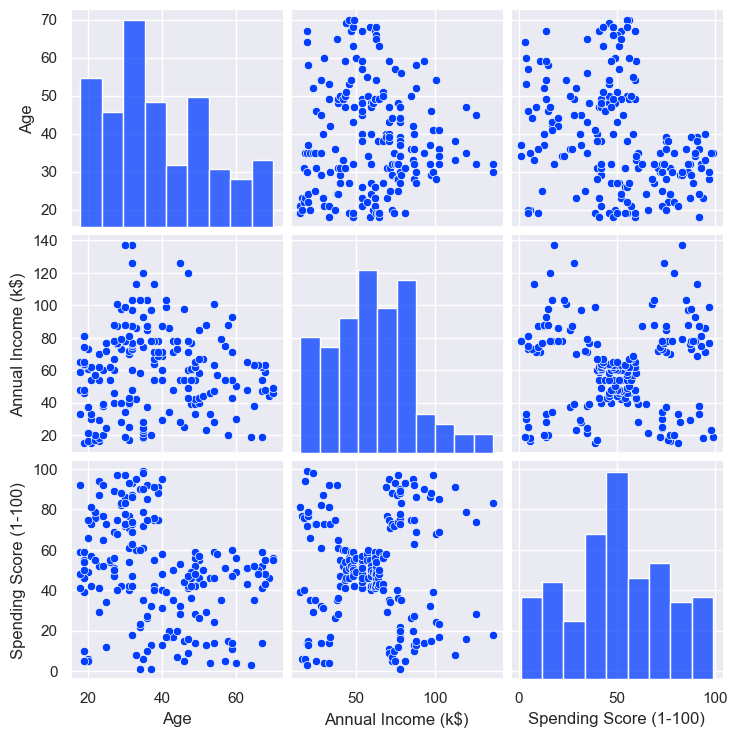

In [18]:
sns.pairplot(df)

#### Definir o modelo KMeans com o número de Clusters e do PCA definido acima

In [19]:
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ('pca', PCA(n_components=3, random_state=RANDOM_STATE)),
    ('clustering', KMeans(n_clusters=5, n_init= 10, random_state=RANDOM_STATE))
])  

pipeline.fit(df)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                                 ('one_hot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=3, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [20]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard', StandardScaler(),
                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                 ('one_hot', OneHotEncoder(), ['Gender'])]),
 'pca': PCA(n_components=3, random_state=42),
 'clustering': KMeans(n_clusters=5, n_init=10, random_state=42)}

#### Adicionando os clusters no dataframe original

In [21]:
pipeline['clustering'].labels_

array([1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 1, 3,
       0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 1,
       0, 3, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 4, 1, 4, 2, 4, 2, 4, 2, 4,
       1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4], dtype=int32)

In [22]:
df_clustered = df.copy()
df_clustered['cluster'] = pipeline['clustering'].labels_
df_clustered

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,3
2,Female,20,16,6,1
3,Female,23,16,77,3
4,Female,31,17,40,1
...,...,...,...,...,...
195,Female,35,120,79,4
196,Female,45,126,28,2
197,Male,32,126,74,4
198,Male,32,137,18,2


In [23]:
df_clustered['cluster'].value_counts().sort_index()

# Para analisar a quantidade de clientes em cada cluster

cluster
0    58
1    47
2    34
3    22
4    39
Name: count, dtype: int64

In [24]:
df_clustered.groupby('cluster').describe().T

cluster                               0          1           2          3  \
Age                    count  58.000000  47.000000   34.000000  22.000000   
                       mean   55.551724  27.957447   41.264706  25.272727   
                       std     8.324920   7.309783   10.768385   5.257030   
                       min    42.000000  18.000000   19.000000  18.000000   
                       25%    49.000000  21.000000   34.500000  21.250000   
                       50%    53.500000  27.000000   42.500000  23.500000   
                       75%    63.750000  34.500000   47.000000  29.750000   
                       max    70.000000  40.000000   59.000000  35.000000   
Annual Income (k$)     count  58.000000  47.000000   34.000000  22.000000   
                       mean   48.482759  50.000000   88.500000  25.727273   
                       std    13.797077  16.704595   16.533254   7.566731   
                       min    19.000000  15.000000   71.000000  15.000000   
                       25%    40.500000  40.000000   77.250000  19.250000   
                       50%    49.000000  54.000000   85.500000  24.500000   
                       75%    60.000000  62.000000   97.750000  32.250000   
                       max    79.000000  76.000000  137.000000  39.000000   
Spending Score (1-100) count  58.000000  47.000000   34.000000  22.000000   
                       mean   41.775862  44.638298   16.764706  79.363636   
                       std    15.658688  13.029107    9.881292  10.504174   
                       min     3.000000   6.000000    1.000000  61.000000   
                       25%    37.250000  40.000000   10.000000  73.000000   
                       50%    46.000000  47.000000   15.500000  77.000000   
                       75%    52.000000  54.500000   22.750000  85.750000   
                       max    60.000000  61.000000   39.000000  99.000000   

cluster                                4  
Age                    count   39.000000  
                       mean    32.692308  
                       std      3.728650  
                       min     27.000000  
                       25%     30.000000  
                       50%     32.000000  
                       75%     35.500000  
                       max     40.000000  
Annual Income (k$)     count   39.000000  
                       mean    86.538462  
                       std     16.312485  
                       min     69.000000  
                       25%     75.500000  
                       50%     79.000000  
                       75%     95.000000  
                       max    137.000000  
Spending Score (1-100) count   39.000000  
                       mean    82.128205  
                       std      9.364489  
                       min     63.000000  
                       25%     74.500000  
                       50%     83.000000  
                       75%     90.000000  
                       max     97.000000

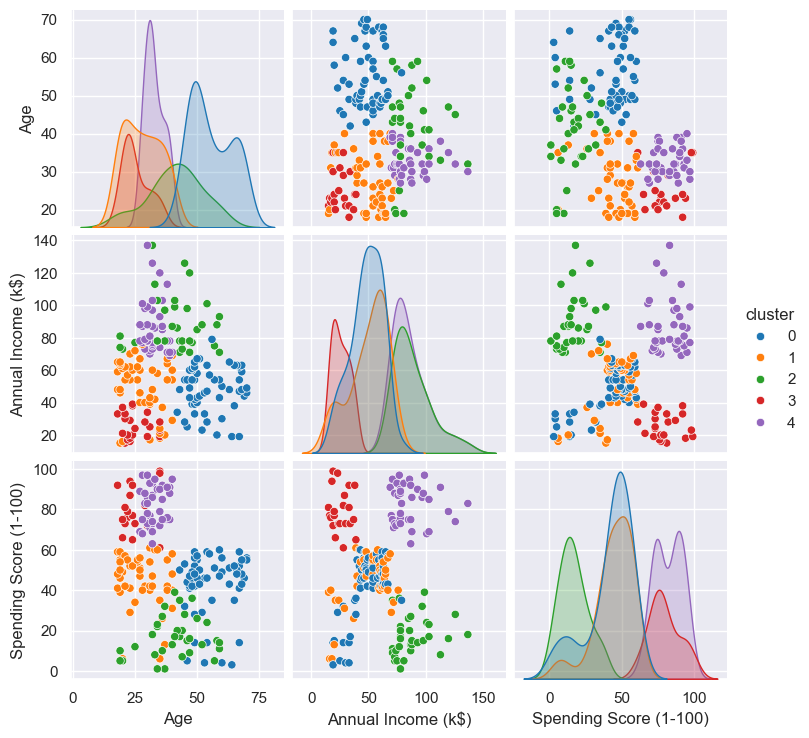

In [25]:
sns.pairplot(df_clustered, hue='cluster', palette='tab10')

[]

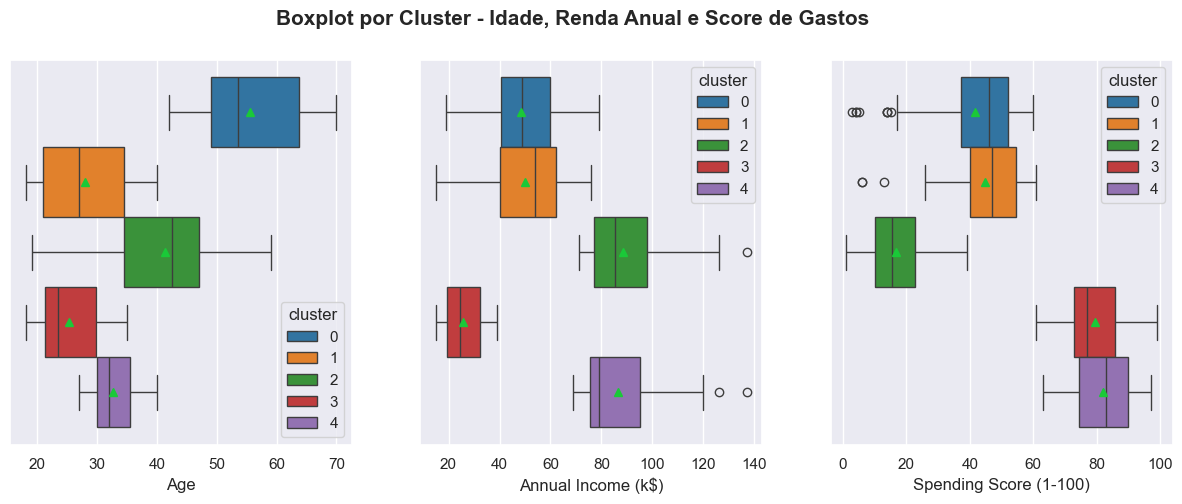

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)

for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes('number')):
    sns.boxplot(
        data=df_clustered, 
        x=coluna, 
        ax=ax, 
        showmeans=True, 
        hue='cluster',
        palette='tab10'
    )

fig.suptitle('Boxplot por Cluster - Idade, Renda Anual e Score de Gastos', fontsize=15, fontweight='bold',)

plt.plot()  

#### **Definição dos Clusters**
- Cluster 0: adultos ou idosos, renda moderada, pontuação moderada
- Cluster 1: jovens e adultos, renda moderada, pontuação moderada
- Cluster 2: adultos, renda alta, pontuação baixa
- Cluster 3: jovens, renda baixa, pontuação alta 
- Cluster 4: jovens e adultos, renda alta, pontuação alta

Transformando os pontos acima em uma tabela

| Pontuação de Gastos | Renda | Idade | Cluster |
|---------------------|-------|-------|---------|
| Moderada                | Moderada  | Adultos/Idosos | 0       |
| Moderada            | Moderada | Jovens/Adultos | 1       |
| Baixa                | Alta | Adultos | 2       |
| Alta               | Baixa  | Jovens | 3       |
| Alta            | Alta | Jovens/Adultos | 4       |

OBS: Podemos entender se tem alguma variação entre generos.

#### Analisando as diferenças entre gênero

[]

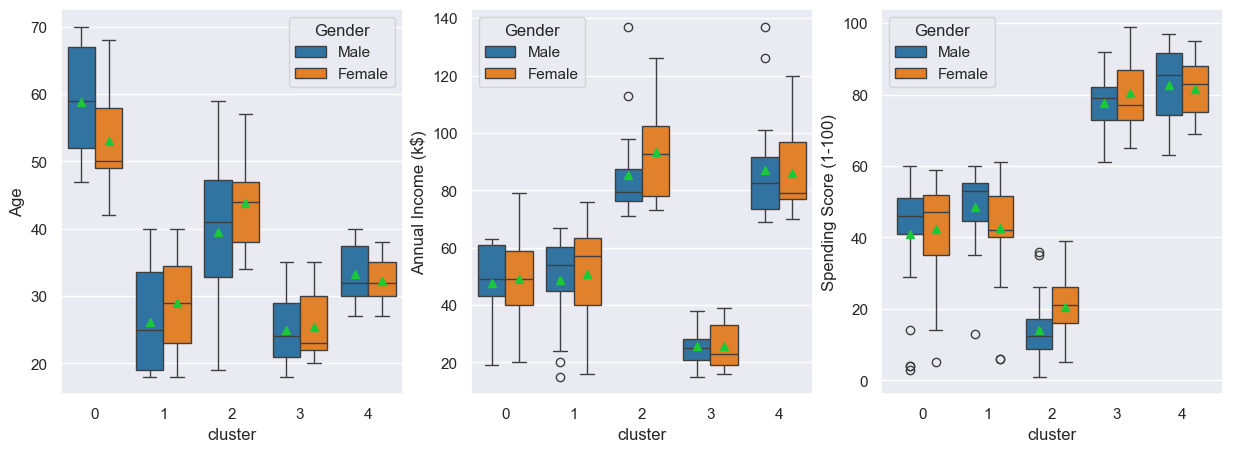

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes('number')):
    sns.boxplot(
        data=df_clustered, 
        x='cluster',
        y=coluna, 
        ax=ax, 
        showmeans=True, 
        hue='Gender',
        palette='tab10',
)

plt.plot()  

**OBS**: Nada muito significativo

In [28]:
df_clustered.groupby(by=['cluster', 'Gender']).size()

# Vejamos que os cluster até que estão bem distribuídos, não tem algum cluster que tem poucos dados de homem ou mulher só

cluster  Gender
0        Female    33
         Male      25
1        Female    31
         Male      16
2        Female    14
         Male      20
3        Female    13
         Male       9
4        Female    21
         Male      18
dtype: int64

#### Analisando os Clusters Graficamente

In [29]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard', StandardScaler(),
                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                 ('one_hot', OneHotEncoder(), ['Gender'])]),
 'pca': PCA(n_components=3, random_state=42),
 'clustering': KMeans(n_clusters=5, n_init=10, random_state=42)}

In [30]:
pipeline['preprocessamento'].get_feature_names_out()

array(['standard__Age', 'standard__Annual Income (k$)',
       'standard__Spending Score (1-100)', 'one_hot__Gender_Female',
       'one_hot__Gender_Male'], dtype=object)

In [31]:
pipeline['pca'].components_       # É o peso que cada um dos parametros acima tem pra cada componente do PCA

array([[ 0.70508424, -0.03921531, -0.70473508, -0.04830549,  0.04830549],
       [ 0.02024387,  0.996115  , -0.02730038, -0.05744471,  0.05744471],
       [ 0.70661643,  0.00434967,  0.70753413, -0.00590595,  0.00590595]])

In [32]:
pipeline['pca'].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [33]:
pipeline['clustering'].cluster_centers_

# A linha 1 corresponde o centroide do cluster 1 para as colunas pc0, pc1 e pc2
# A linha 2 corresponde o centroide do cluster 2 para as colunas pc0, pc1 e pc2 ....

array([[ 1.09281997, -0.42702742,  0.61346816],
       [-0.39283157, -0.42287385, -0.70807382],
       [ 1.00944112,  1.11828568, -0.78954352],
       [-1.4357643 , -1.37856558,  0.10638215],
       [-1.2219143 ,  0.94742028,  0.56929202]])

In [34]:
pipeline[:-1]

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                                 ('one_hot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=3, random_state=42))])

In [35]:
df_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(df),
    columns=pipeline['pca'].get_feature_names_out()
)
df_pca.head()

,pca0,pca1,pca2
0,-0.575724,-1.684874,-1.315210
1,-1.623595,-1.726481,-0.060149
2,0.279614,-1.725314,-2.182574
3,-1.511064,-1.796205,-0.080242
4,-0.095468,-1.707347,-0.690684


In [36]:
# Forma mais composta de substituir o pipeline[:-1]

df_pca = pd.DataFrame(
    pipeline['pca'].fit_transform(pipeline['preprocessamento'].fit_transform(df)),
    columns=pipeline['pca'].get_feature_names_out()
)
df_pca.head()

,pca0,pca1,pca2
0,-0.575724,-1.684874,-1.315210
1,-1.623595,-1.726481,-0.060149
2,0.279614,-1.725314,-2.182574
3,-1.511064,-1.796205,-0.080242
4,-0.095468,-1.707347,-0.690684


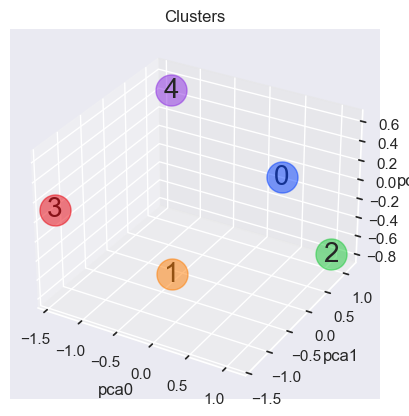

In [37]:
from src.graficos import visualizar_clusters_3d

centroides = pipeline['clustering'].cluster_centers_  

visualizar_clusters_3d(
    df_pca,                             
    colunas=['pca0', 'pca1', 'pca2'],
    quantidade_cores_clusters=5,
    centroids=centroides,
    mostrar_centroids=True,
    mostrar_pontos=False,
)

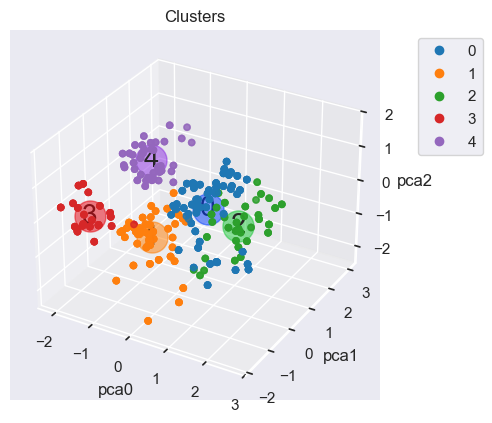

In [38]:
centroides = pipeline['clustering'].cluster_centers_  

visualizar_clusters_3d(
    df_pca,                              
    colunas=['pca0', 'pca1', 'pca2'],
    quantidade_cores_clusters=5,
    centroids=centroides,
    mostrar_centroids=True,
    mostrar_pontos=True,
    coluna_clusters=df_clustered['cluster']
)

#### Gráficos 2d

In [39]:
df_pca.head(3)

,pca0,pca1,pca2
0,-0.575724,-1.684874,-1.315210
1,-1.623595,-1.726481,-0.060149
2,0.279614,-1.725314,-2.182574


In [40]:
centroids = pipeline['clustering'].cluster_centers_
centroids

array([[ 1.09281997, -0.42702742,  0.61346816],
       [-0.39283157, -0.42287385, -0.70807382],
       [ 1.00944112,  1.11828568, -0.78954352],
       [-1.4357643 , -1.37856558,  0.10638215],
       [-1.2219143 ,  0.94742028,  0.56929202]])

In [41]:
print(centroids[:, 0])     # Posição dos centroides de cada cluster para a coluna 'pc0'
print(centroids[:, 1])     # Posição dos centroides de cada cluster para a coluna 'pc1'
print(centroids[:, 2])     # Posição dos centroides de cada cluster para a coluna 'pc2'


[ 1.09281997 -0.39283157  1.00944112 -1.4357643  -1.2219143 ]
[-0.42702742 -0.42287385  1.11828568 -1.37856558  0.94742028]
[ 0.61346816 -0.70807382 -0.78954352  0.10638215  0.56929202]


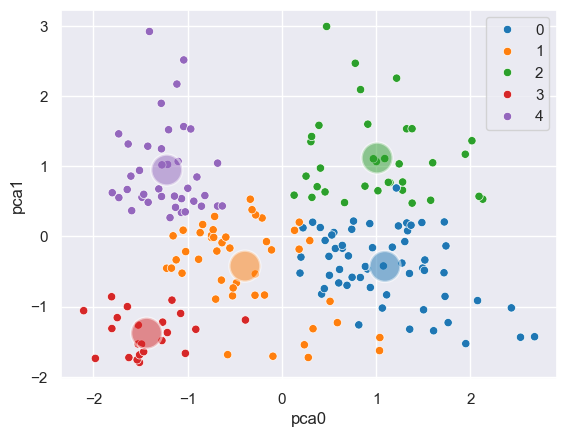

In [42]:
fig, ax = plt.subplots()

pc0, pc1, pc2 = df_pca.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=pc0,
    y=pc1,
    data=df_pca,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 0],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 1],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

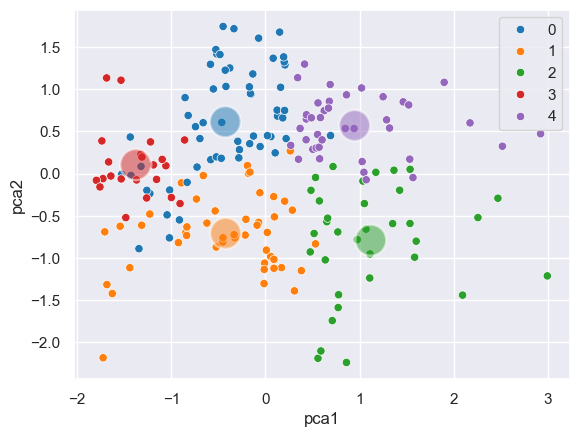

In [43]:
fig, ax = plt.subplots()

pc0, pc1, pc2 = df_pca.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=pc1,
    y=pc2,
    data=df_pca,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 1],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 2],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

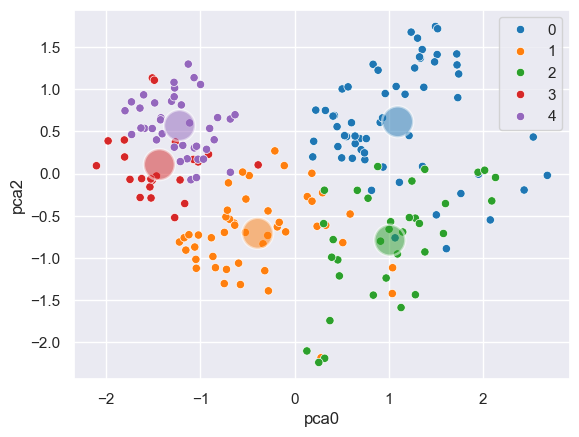

In [44]:
fig, ax = plt.subplots()

pc0, pc1, pc2 = df_pca.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=pc0,
    y=pc2,
    data=df_pca,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 0],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 2],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

#### Entender quais features tem mais peso para cada PCA

In [45]:
pipeline['pca'].components_

array([[ 0.70508424, -0.03921531, -0.70473508, -0.04830549,  0.04830549],
       [ 0.02024387,  0.996115  , -0.02730038, -0.05744471,  0.05744471],
       [ 0.70661643,  0.00434967,  0.70753413, -0.00590595,  0.00590595]])

In [46]:
pipeline['preprocessamento'].get_feature_names_out()

array(['standard__Age', 'standard__Annual Income (k$)',
       'standard__Spending Score (1-100)', 'one_hot__Gender_Female',
       'one_hot__Gender_Male'], dtype=object)

In [47]:
pd.DataFrame(
    data=pipeline['pca'].components_.T,
    index=pipeline['preprocessamento'].get_feature_names_out(),
    columns=pipeline['pca'].get_feature_names_out()
)

,pca0,pca1,pca2
standard__Age,0.705084,0.020244,0.706616
standard__Annual Income (k$),-0.039215,0.996115,0.004350
standard__Spending Score (1-100),-0.704735,-0.027300,0.707534
one_hot__Gender_Female,-0.048305,-0.057445,-0.005906
one_hot__Gender_Male,0.048305,0.057445,0.005906


#### Analisando graficamente dados originais separados por clusters

In [48]:
df_clustered

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,3
2,Female,20,16,6,1
3,Female,23,16,77,3
4,Female,31,17,40,1
...,...,...,...,...,...
195,Female,35,120,79,4
196,Female,45,126,28,2
197,Male,32,126,74,4
198,Male,32,137,18,2


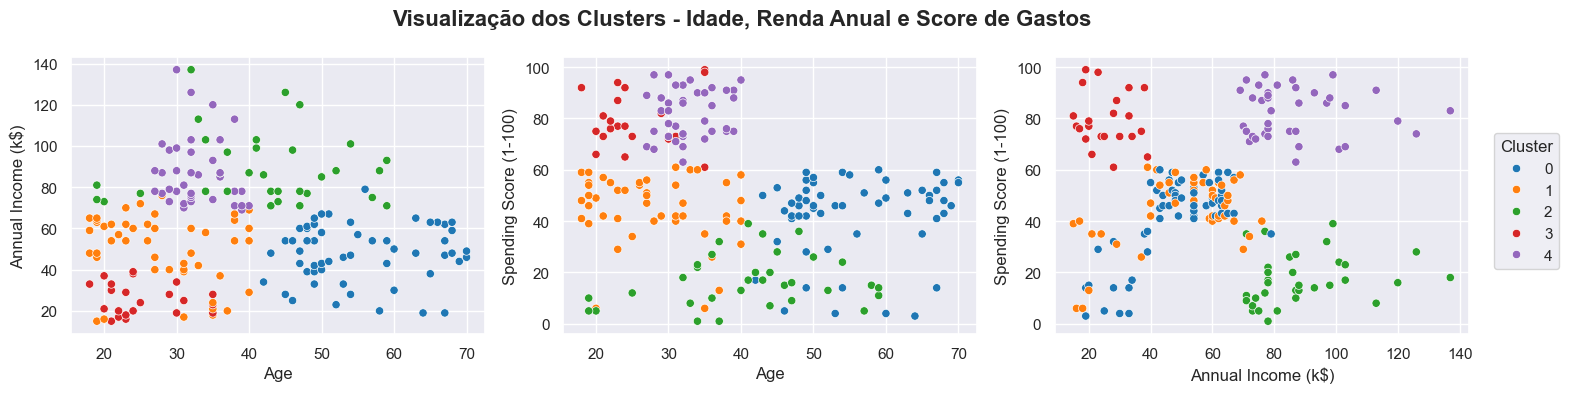

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

Gender, Age, Annual_Income, Spending_Score, cluster = df_clustered.columns

sns.scatterplot(
    x=Age,
    y=Annual_Income,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[0],
    legend=False
)

sns.scatterplot(
    x=Age,
    y=Spending_Score,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[1],
    legend=False
)

sns.scatterplot(
    x=Annual_Income,
    y=Spending_Score,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[2],
    legend= 'full'
)

fig.suptitle('Visualização dos Clusters - Idade, Renda Anual e Score de Gastos', fontsize=16, fontweight='bold',)

# Deixando a legenda centralizada a direita
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend_.remove()
fig.legend(handles=handles, labels=labels, loc='center right', bbox_to_anchor=(1.05, 0.5), title='Cluster')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


#### Exportando o modelo

In [50]:
import joblib

joblib.dump(pipeline, "../modelos/pipeline_preprocessamento_pca_clustering.pkl")

['../modelos/pipeline_preprocessamento_pca_clustering.pkl']